Установить библиотеки: pandas - для работы с таблицами, pyreadstat - для чтения файлов из статистических программ (типа SPSS), scikit-learn для машинного обучения. Обязательно указать версию библиотеки через ==, потому что код, работающий в одной версии, может не работать в другой.  
Документации на них:

https://pandas.pydata.org

https://ofajardo.github.io/pyreadstat_documentation/_build/html/index.html

https://scikit-learn.org/stable/index.html


In [1]:
!pip install pandas==1.4.2 pyreadstat==1.2.0 scikit-learn==1.2.2 graphviz==0.20.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Подключить Google Disk, надо будет дать разрешение этой jupyter-notebook тетрадке на чтение/запись с него. Файлы *.sav должны быть заранее загружены на Google Disk в папку коуж. Если они загружены по другому пути, надо будет поменять переменную fpath (cм. ниже)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Предупреждение: код тестировался только на Псковской области. В случае любых странностей при выборе другого региона писать в чат своей группы в телеграме (в чате потока меня нет)

In [3]:
# импортируем библиотеку pyreadstat, 
# которая ориентирована на работу с форматами статистических (в т.ч., платных) программ.
import pyreadstat
import numpy as np

In [4]:
from datetime import datetime # для уникальных имен файлов с графом дерева
import os

import graphviz # для отрисовки графа дерева
from graphviz import render

from sklearn.linear_model import LogisticRegression # классификатор логистическая регрессия
from sklearn.tree import DecisionTreeClassifier # классификатор дерево решений
from sklearn import tree
from sklearn.metrics import classification_report # считает метрики точность, полнота, f-мера
from sklearn.model_selection import train_test_split # разбиение на тестовую и обучающую выборки

In [5]:
# Источник данных: https://gks.ru/ .

fpath_2020 = 'drive/MyDrive/коуж/IND_OSN_2020.sav'
df_2020, meta_2020 = pyreadstat.read_file_multiprocessing(pyreadstat.read_sav, fpath_2020, num_processes=16, encoding='cp1251') 


In [6]:
selection = [
    'I08_04', # Частота выходов в сеть Интернет',
    "R_1_1", # размер населённого пункта
    "R_1", # место проживания
    "H00_04", # тип населённого пункта
    "H00_02", # код субъекта РФ
    'I05_141', #'Использование компьютерной техники на основной работе, хотя бы, один раз в неделю',
    'H01_02', #'Число исполнившихся лет',
    'I05_15', #'Потребность в получении знаний в области информационных технологий',
    'I05_151', #'Позволяет ли характер работы выполнять ее дистанционно, через Интернет',
    'I06_07_05', #'Отсутствие технических устройств для выхода в Интернет',
    'I06_07_06', # 'Отсутствие мобильной связи и сети «Интернет»,  в т.ч. перебои в их работе',
    'PENS_UST', # Лица, получающие пенсию, назначенную в год достижения общеустановленного пенсионного возраста
    'DEN_NA_DUSHU', # Денежный доход в среднем на члена ДХ, в месяц, рублей
    ] 

In [7]:
def select_region(df, meta, selection):
    # Создадим новую таблицу (pandas DataFrame), но только с теми колонками,
    # которые используются в расчётах.
    # Так используется меньше памяти, удобнее визуализировать. Но можно пользоваться и исходной таблицей.
    selected = df[selection]
    # Используем генератор списков, чтобы переименовать служебные заголовки в читаемые.
    # для этого мы хотим "пройтись" по всем меткам в списке selection и получить новый список вместо selection.
    # Подробнее о генераторах списков: https://pythontutor.ru/lessons/lists/#section_3
    selection_names = [meta.column_names_to_labels[label].strip() for label in selection]
    # Заменим исходные наименования колонок на наименования из получившегося списка selection_names, 
    # теперь у нас наименования колонок будет как в столбце "метки" файла sav.
    selected.columns = selection_names
    # 58 - код Псковской области, согласно ОКАТО (без 11).
    # создаем маску, чтобы получить таблицу с данными только по Псковской области.
    mask = selected['Код субъекта РФ'] == '58'
    # применяем маску - используем только те строчки, где значения маски True
    region = selected[mask]
    # число наблюдений в таблице получаем через атрибут shape.
    # так как в shape находится объект типа кортеж (tuple)- структура данных, похожая на список,
    # но неизменяемая (чтобы добавить или удалить элемент, придется создавать новый объект типа кортеж в памяти).
    # из кортежа,  так же, как из списка, можно получить по порядковому индексу его элемент
    # в данном случае у нас shape[0] - количество строк, shape[1] - количество столбцов.
    # pandas DataFrame - двумерная таблица, ее размерность описывается количеством строчек и столбцов.
    # одномерная "таблица" pandas, по сути, одна колонка, размерность которой описывается только количеством строчек,
    # называется Series
    region = region.fillna(value=-1) # вопросы с ответами по номинальной шкале бывают устроены так, что 1 значит да, пропущенное значение значит нет
    # а бывает, что 1 значит да, 2 значит нет.
    print(f"Количество наблюдений по данному региону: {region.shape[0]}")
    return region

In [8]:
print("2020 ГОД")
region = select_region(df_2020, meta_2020, selection)
region.head()

2020 ГОД
Количество наблюдений по данному региону: 711


,Частота выходов в сеть Интернет,Размер населенного пункта,Место проживания,Тип населенного пункта,Код субъекта РФ,"Использование компьютерной техники на основной работе, хотя бы, один раз в неделю",Число исполнившихся лет,Потребность в получении знаний в области информационных технологий,"Позволяет ли характер работы выполнять ее дистанционно, через Интернет",Отсутствие технических устройств для выхода в Интернет,"Отсутствие мобильной связи и сети «Интернет», в т.ч. перебои в их работе","Лица, получающие пенсию, назначенную в год достижения общеустановленного пенсионного возраста","Денежный доход в среднем на члена ДХ, в месяц, рублей"
64772,4.0,3.0,1.0,1.0,58,-1.0,85.0,-1.0,-1.0,-1.0,-1.0,1.0,17500.0
64773,4.0,3.0,1.0,1.0,58,-1.0,68.0,-1.0,-1.0,-1.0,-1.0,1.0,17500.0
64774,2.0,3.0,1.0,1.0,58,1.0,58.0,1.0,3.0,-1.0,-1.0,1.0,35000.0
64775,1.0,3.0,1.0,1.0,58,1.0,54.0,2.0,3.0,-1.0,-1.0,-1.0,22500.0
64776,1.0,3.0,1.0,1.0,58,1.0,46.0,1.0,2.0,-1.0,-1.0,-1.0,22500.0


Вопрос 1: можно ли предсказать возрастную группу человека по частоте выхода в интернет?

In [9]:
def age_2_group(x):
    """Функция, чтобы преобразовать возраста в возрастные группы "дети", "работающие" и "пенсионеры"""""
    if x < 18:
        return 0
    elif (x>=18 and x < 65):
        return 1
    else:
        return 2

Какие метрики используются https://en.wikipedia.org/wiki/F-score

In [10]:
# посмотреть, какие есть значения для переменной Частота выходов в сеть Интернет
meta_2020.value_labels[meta_2020.variable_to_label['I08_04']]

{1.0: 'Каждый день или почти каждый день',
 2.0: 'Один или несколько раз в неделю',
 3.0: 'От случаю к случаю',
 4.0: 'Не пользуются'}

In [11]:
region = select_region(df_2020, meta_2020, selection)
region['age_group'] =  region['Число исполнившихся лет'].apply(age_2_group)
X = region[['Частота выходов в сеть Интернет']]
y = region['age_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)
logreg_classifier = LogisticRegression(multi_class='ovr') # создать объект класса Логистическая Регрессия
# multi_class ovr значит что в случае когда классов больше 2, для каждого решается задача классификации его от остальных (one versus rest)
logreg_classifier.fit(X_train, y_train) # обучить
y_pred = logreg_classifier.predict(X_test) # предсказать
print(classification_report(y_test, y_pred)) # распечатать метрики
dt_classifier = DecisionTreeClassifier() # создать объект класса Дерево решений
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

Количество наблюдений по данному региону: 711
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        32
           1       0.84      0.89      0.87       104
           2       0.72      0.67      0.69        42

    accuracy                           0.84       178
   macro avg       0.85      0.81      0.83       178
weighted avg       0.84      0.84      0.84       178

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        32
           1       0.84      0.89      0.87       104
           2       0.72      0.67      0.69        42

    accuracy                           0.84       178
   macro avg       0.85      0.81      0.83       178
weighted avg       0.84      0.84      0.84       178



Интерпретация коэффициентов регрессии: чем больше модуль коэффициента, тем больше этот признак влияет на переменную, которая предсказывается

---



In [12]:
# коэффициенты признака частота выхода в интернет для каждого класса, порядок в атрибуте coef_ такой же, как в classes_
print(logreg_classifier.coef_)
print(logreg_classifier.classes_)

[[-3.38743922]
 [-0.02511353]
 [ 1.13659249]]
[0 1 2]


На этом примере логистическая регрессия и дерево решений работают с одинаковым качеством. Предположение, почему качество для класса пенсионеров хуже: частота выхода в интернет связана с тем, работает ли человек, а возраст выхода на пенсию бывает разный, необязательно именно 65. Чтобы его проверить, надо было бы группировать не только по возрасту.

Рассказать все концепты, необходимые для понимания, как работают логистическая регрессия и дерево решений, за одно занятие не получится.
Кому интересно, можно посоветовать книгу Борхани Реза, Катсаггелос Аггелос, Уатт Джереми "Машинное обучение: основы, алгоритмы и практика применения". (Также можно найти много объяснений в гугле, но неполные и упрощенные объяснения обычно только больше запутывают).

Вопрос 2: существует ли цифровое неравенство между большими и малыми городами?

In [13]:
# посмотреть, какие есть значения для переменной размер населенного пункта
meta_2020.value_labels[meta_2020.variable_to_label['R_1_1']]

{1.0: 'городской,  менее 50,0 тыс.чел',
 2.0: 'городской,  50,0 - 99,9 тыс.чел',
 3.0: 'городской,  100,0 - 249,9 тыс.чел',
 4.0: 'городской,  250,0 - 499,9 тыс.чел',
 5.0: 'городской,  500,0 - 999,9 тыс.чел',
 6.0: 'городской,  1 млн. и более',
 7.0: 'сельский,  200 чел. и менее',
 8.0: 'сельский,  201 - 1000 чел.',
 9.0: 'сельский,  1001 - 5000 чел.',
 10.0: 'сельский,  более 5000 чел.'}

In [14]:
def punkt_2_group(x):
    """Присвоить метки класса большим и малым городам. Для других регионов может быть смысл попробовать группировать иначе"""
    if x in {3}:
        return 0
    elif x in {8, 9}:
        return np.nan
    elif x in {1, 2}:
        return 1

In [15]:
features = [
        'Частота выходов в сеть Интернет',
        'Использование компьютерной техники на основной работе, хотя бы, один раз в неделю',
        'Позволяет ли характер работы выполнять ее дистанционно, через Интернет',
        'Потребность в получении знаний в области информационных технологий',
        'Отсутствие технических устройств для выхода в Интернет',
        'Отсутствие мобильной связи и сети «Интернет»,  в т.ч. перебои в их работе',
        'Денежный доход в среднем на члена ДХ, в месяц, рублей',
        ]

In [16]:
region = select_region(df_2020, meta_2020, selection)

print(f"Уникальные значения переменной размер населенного пункта: {region['Размер населенного пункта'].unique()}")
region['punkt_group'] =  region['Размер населенного пункта'].apply(punkt_2_group)
region = region.dropna()
X = region[features]
y = region['punkt_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)
y_pred = logreg_classifier.predict(X_test)
print(classification_report(y_test, y_pred))
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

Количество наблюдений по данному региону: 711
Уникальные значения переменной размер населенного пункта: [3. 1. 2. 9. 8.]
              precision    recall  f1-score   support

         0.0       0.43      0.07      0.12        45
         1.0       0.62      0.95      0.75        74

    accuracy                           0.61       119
   macro avg       0.53      0.51      0.43       119
weighted avg       0.55      0.61      0.51       119

              precision    recall  f1-score   support

         0.0       0.54      0.58      0.56        45
         1.0       0.73      0.70      0.72        74

    accuracy                           0.66       119
   macro avg       0.64      0.64      0.64       119
weighted avg       0.66      0.66      0.66       119



Такое соотношение метрик для двух классов говорит о том, что моделями в большинстве случаев просто выбирается наиболее часто встречающийся класс, качество модели низкое. (Для задачи в реальной жизни такие модели использовать было бы нельзя).

Можно попробовать "почистить" данные, например, удалить из них пенсионеров - возрастную группу, которая плохо предсказывалась по переменной "Частота выхода в интернет"

In [17]:
def without_pensionists(df_2020, meta_2020, selection, features):
    region = select_region(df_2020, meta_2020, selection)
    # исключим пенсионеров из рассматриваемых наблюдений
    region = region[region['Лица, получающие пенсию, назначенную в год достижения общеустановленного пенсионного возраста']!=1]

    print(f"Уникальные значения переменной размер населенного пункта: {region['Размер населенного пункта'].unique()}")
    region['punkt_group'] =  region['Размер населенного пункта'].apply(punkt_2_group)
    region = region.dropna()
    X = region[features]
    y = region['punkt_group']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)
    logreg_classifier = LogisticRegression()
    logreg_classifier.fit(X_train, y_train)
    y_pred = logreg_classifier.predict(X_test)
    print(classification_report(y_test, y_pred))
    dt_classifier = DecisionTreeClassifier()
    dt_classifier.fit(X_train, y_train)
    y_pred = dt_classifier.predict(X_test)
    print(classification_report(y_test, y_pred))
    # сохраним граф дерева в файл и запишем в переменную, чтобы вывести в другой ячейке
    # добавим текущее время с точностью до миллисекунды в название файла, чтобы не перезаписывать при каждом запуске предыдущий результат
    # и количество признаков, чтобы различать эксперименты между собой
    # есть специальные библиотеки для версионирования экспериментов машинного обучения, например, mlflow, но это за рамками данного курса
    filename = 'drive/MyDrive/' + f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')}" + f'-{len(features)}-features{os.path.extsep}dot'
    tree.export_graphviz(dt_classifier, out_file=filename, 
                         feature_names=X_train.columns,  
                         class_names=['городской,  100,0 - 249,9 тыс.чел', 'городской,  менее 99,9 тыс.чел'],  
                         filled=True, rounded=True,  
                         special_characters=True)
    # если параметр out_file функции export_graphviz не None, граф запишется в файл в формате dot
    graph = graphviz.Source.from_file(filename)  # читаем из файла в формате dot в переменную
    render('dot', 'png', filename) # конвертация из формата dot в png - на диске появится еще один файлик, который можно будет 
    # открыть в обычной программе просмотра картинок
    return graph

In [18]:
graph = without_pensionists(df_2020, meta_2020, selection, features)

Количество наблюдений по данному региону: 711
Уникальные значения переменной размер населенного пункта: [3. 1. 2. 9. 8.]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        28
         1.0       0.67      1.00      0.80        56

    accuracy                           0.67        84
   macro avg       0.33      0.50      0.40        84
weighted avg       0.44      0.67      0.53        84

              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76        28
         1.0       0.89      0.86      0.87        56

    accuracy                           0.83        84
   macro avg       0.81      0.82      0.82        84
weighted avg       0.84      0.83      0.83        84


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


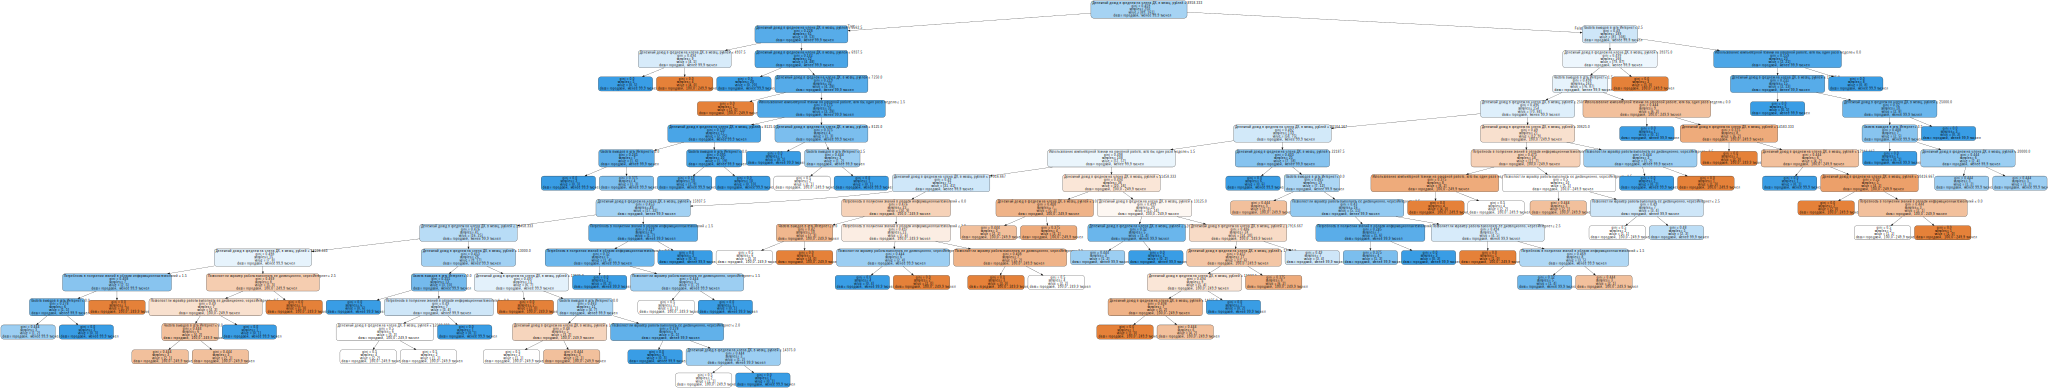

In [19]:
graph

Качество улучшилось, но только для дерева решений, что говорит о том, что множества наших наблюдений, относящиеся к двум классам, не являются линейно разделимыми по заданным признакам.

https://en.wikipedia.org/wiki/Linear_separability - определение линейной разделимости

Возможно ли, что данный результат отражает неравенство по доходам, а не цифровое? Оставим только одну переменную, касающуюся дохода.

In [20]:
graph = without_pensionists(df_2020, meta_2020, selection, ['Денежный доход в среднем на члена ДХ, в месяц, рублей'])

Количество наблюдений по данному региону: 711
Уникальные значения переменной размер населенного пункта: [3. 1. 2. 9. 8.]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        28
         1.0       0.67      1.00      0.80        56

    accuracy                           0.67        84
   macro avg       0.33      0.50      0.40        84
weighted avg       0.44      0.67      0.53        84

              precision    recall  f1-score   support

         0.0       0.68      0.61      0.64        28
         1.0       0.81      0.86      0.83        56

    accuracy                           0.77        84
   macro avg       0.75      0.73      0.74        84
weighted avg       0.77      0.77      0.77        84



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


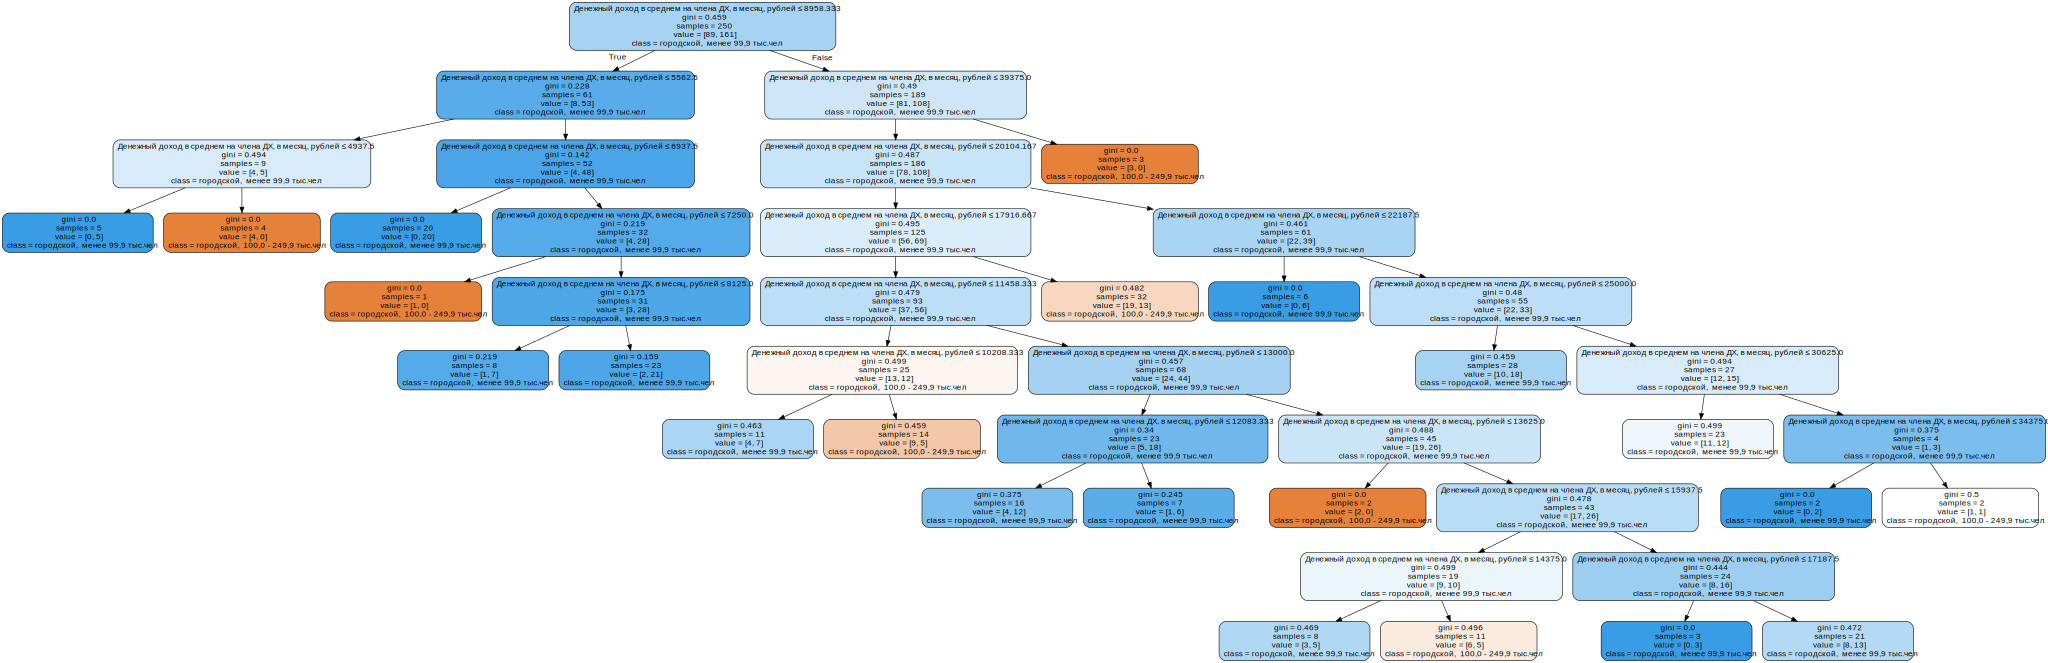

In [21]:
graph

Результат ухудшился, таким образом, неравенство между большими и малыми городами в Псковской области выражается не только в доходах, но и в степени цифровизации.

Остаются нерассмотренными вопросы: 

- кросс-валидация (сохраняется ли удовлетворительный результат при других разбиениях на обучающую и тестовую выборку?)
- можно ли улучшить качество, подобрав гиперпараметры классификаторов? 
- как будет изменяться результат при удалении других признаков и добавлении новых?

Если бы это была задача для работы в реальной жизни, то на эти вопросы стоило бы ответить.